In [1]:
from table_evaluator import TableEvaluator

import tensorflow as tf

from functools import partial
import itertools
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Embedding, multiply, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import warnings
warnings.simplefilter("ignore")

Check how many GPUs there is avaliable for training:

In [2]:
try:
    gpus = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("Physical GPUs:", len(gpus))
    print("Logical GPUs:", len(logical_gpus))

except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Physical GPUs: 1
Logical GPUs: 1


### Read data

Data pre-processing steps are as follows:


- Standardization `sklearn.preprocessing.StandardScaler`
- PCA             `sklearn.decomposition.PCA`
- Normalization   `sklearn.preprocessing.Normalizer`


Out of the myriad tested combinations of pre-processing steps, these were shown to give best results when preparing [CIC-IDS-2017](https://www.unb.ca/cic/datasets/ids-2017.html) dataset for training.

Data pre-processing code can be found in the [data-preproc.ipynb]() file.

---

_**Note:** This pre-processing workflow was shown to be optimal in this case, yours may differ._

In [3]:
x_train = np.load("data/x_train.npy")
y_train = np.load("data/y_train.npy")

### Model Definition

In [4]:
class RandomWeightedAverage(tf.keras.layers.Layer):
    """Provides a (random) weighted average between real and generated samples"""
    
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    
    def call(self, inputs, **kwargs):
        alpha = tf.random.uniform((self.batch_size, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]

class WCGANGP():
    def __init__(self, 
                 x_train, 
                 y_train, 
                 latent_dim: int, 
                 batch_size: int,
                 n_critic: int):
        """Implement WCGAN with Gradient Penalty.
        
        Most of the hyperparameteres were taken from this paper:
        https://www.researchgate.net/publication/347437993_Synthesising_Tabular_Data_using_Wasserstein_Conditional_GANs_with_Gradient_Penalty_WCGAN-GP
        
        and from the Improved WGAN paper:
        https://arxiv.org/abs/1704.00028
        
        Attributes
        ---------
        x_train : numpy.ndarray
            Real data without labels used for training.
            (Created with sklearn.model_selection.train_test_split
        
        y_train : numpy.ndarray
            Real data labels.
            
        data_dim : int
            Data dimension. Number of columns in `x_train`.
            
        latent_dim : int
            Dimension of random noise vector (z), used for training
            the generator.
            
        batch_size : int
            Size of training batch in each epoch.
        
        n_critic : int
            Number of times the critic (discriminator) will be trained
            in each epoch.

        """
        
        self.x_train = x_train
        self.y_train = y_train
        
        self.num_classes = len(np.unique(y_train))
        self.data_dim = x_train.shape[1]
        
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        
        self.n_critic = n_critic
        
        # Log training progress.
        self.losslog = []

        # Adam optimizer, suggested by original paper.
        optimizer = Adam(learning_rate=0.0005, beta_1=0.05, beta_2=0.9)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        
        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic.
        self.generator.trainable = False

        # Data input (real sample).
        real_data = Input(shape=self.data_dim)
        # Noise input (z).
        noise = Input(shape=(self.latent_dim,))
        # Label input.
        label = Input(shape=(1,))
        
        # Generate data based of noise (fake sample)
        fake_data = self.generator([noise, label])
        
        # Critic (discriminator) determines validity of the real and fake images.
        fake = self.critic([fake_data, label])
        valid = self.critic([real_data, label])
        
        # Construct weighted average between real and fake images.
        interpolated_data = RandomWeightedAverage(self.batch_size)([real_data, fake_data])
        
        # Determine validity of weighted sample.
        validity_interpolated = self.critic([interpolated_data, label])
        
        
        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument.
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_data)
        # Keras requires function names.
        partial_gp_loss.__name__ = 'gradient_penalty' 
        
        self.critic_model = Model(inputs=[real_data, label, noise],
                            outputs=[valid, fake, validity_interpolated])
        
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                  optimizer=optimizer,
                                  loss_weights=[1, 1, 10])
 
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers.
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator.
        noise = Input(shape=(self.latent_dim,))
        
        # Add label to input.
        label = Input(shape=(1,))
        
        # Generate data based of noise.
        fake_data = self.generator([noise, label])

        # Discriminator determines validity.
        valid = self.critic([fake_data, label])

        # Define generator model.
        self.generator_model = Model([noise, label], valid)
        self.generator_model.compile(loss=self.wasserstein_loss, 
                                     optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - abs(gradient_l2_norm))
        
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        """Computes Wasserstein loss from real and fake predictions."""
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential(name="Generator")
        
        # First hidden layer.
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))
        
        # Second hidden layer.
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))
        
        # Third hidden layer.
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))
        
        # Output layer.
        model.add(Dense(self.data_dim, activation="tanh"))
        
        model.summary()
        
        # Noise and label input layers.
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype="int32")
        
        # Embed labels into onehot encoded vectors.
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        
        # Multiply noise and embedded labels to be used as model input.
        model_input = multiply([noise, label_embedding])
        
        generated_data = model(model_input)

        return Model([noise, label], generated_data, name="Generator")

    def build_critic(self):

        model = Sequential(name="Critic")

        # First hidden layer.
        model.add(Dense(1024, input_dim=self.data_dim))
        model.add(LeakyReLU(alpha=0.2))
        
        # Second hidden layer.        
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        
        # Third hidden layer.
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))

        # Output layer with linear activation.
        model.add(Dense(1))

        model.summary()
        
        # Artificial data input.
        generated_sample = Input(shape=self.data_dim)
        # Label input.
        label = Input(shape=(1,), dtype="int32")
        
        # Embedd label as onehot vector.
        label_embedding = Flatten()(Embedding(self.num_classes, self.data_dim)(label))
        
        # Multiply fake data sample with label embedding to get critic input.
        model_input = multiply([generated_sample, label_embedding])
        
        validity = model(model_input)

        return Model([generated_sample, label], validity, name="Critic")

    def train(self, epochs):

        # Adversarial ground truths.
        valid = -(np.ones((self.batch_size, 1)))
        fake =  np.ones((self.batch_size, 1))
        dummy = np.zeros((self.batch_size, 1))
        
        # Number of batches.
        self.n_batches = math.floor(self.x_train.shape[0] / self.batch_size)

        overhead = self.x_train.shape[0] % self.batch_size
        
        for epoch in range(epochs):
                
            # Reset training set.
            self.x_train = x_train.copy()
            self.y_train = y_train.copy()

            # Select random overhead rows that do not fit into batches.
            rand_overhead_idx = np.random.choice(range(self.x_train.shape[0]), overhead, replace=False)

            # Remove random overhead rows.
            self.x_train = np.delete(self.x_train, rand_overhead_idx, axis=0)
            self.y_train = np.delete(self.y_train, rand_overhead_idx, axis=0)

            # Split training data into batches.
            x_batches = np.split(self.x_train, self.n_batches)
            y_batches = np.split(self.y_train, self.n_batches)
            
            for x_batch, y_batch, i in zip(x_batches, y_batches, range(self.n_batches)):
        
                for _ in range(self.n_critic):

                    # ---------------------
                    #  Train Critic
                    # ---------------------

                    # Generate random noise.
                    noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
                             
                    # Train the critic.
                    d_loss = self.critic_model.train_on_batch(
                        [x_batch, y_batch, noise],                                      
                        [valid, fake, dummy])


                # ---------------------
                #  Train Generator
                # ---------------------

                # Generate sample of artificial labels.
                generated_labels = np.random.randint(0, self.num_classes, self.batch_size).reshape(-1, 1)

                # Train generator.
                g_loss = self.generator_model.train_on_batch([noise, generated_labels], valid)


                # ---------------------
                #  Logging
                # ---------------------

                self.losslog.append([d_loss[0], g_loss])
                
                DLOSS = "%.4f" % d_loss[0]
                GLOSS = "%.4f" % g_loss
                
                if i % 100 == 0:
                    print(f"{epoch} - {i}/{self.n_batches} \t [D loss: {DLOSS}] [G loss: {GLOSS}]")


**Model training**

In [5]:
wcgan = WCGANGP(
    x_train, 
    y_train,
    latent_dim=64,
    batch_size=256,
    n_critic=5)

wcgan.train(epochs=15)

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              52

10 - 600/959 	 [D loss: -0.2372] [G loss: -1.6087]
10 - 700/959 	 [D loss: -0.1978] [G loss: -1.4397]
10 - 800/959 	 [D loss: -0.2222] [G loss: -1.4594]
10 - 900/959 	 [D loss: -0.2061] [G loss: -1.4950]
11 - 0/959 	 [D loss: -0.2142] [G loss: -1.5456]
11 - 100/959 	 [D loss: -0.1915] [G loss: -1.4258]
11 - 200/959 	 [D loss: -0.2248] [G loss: -1.4178]
11 - 300/959 	 [D loss: -0.1767] [G loss: -1.5126]
11 - 400/959 	 [D loss: -0.1798] [G loss: -1.4929]
11 - 500/959 	 [D loss: -0.2088] [G loss: -1.4661]
11 - 600/959 	 [D loss: -0.2117] [G loss: -1.5666]
11 - 700/959 	 [D loss: -0.1920] [G loss: -1.4446]
11 - 800/959 	 [D loss: -0.2133] [G loss: -1.5407]
11 - 900/959 	 [D loss: -0.2031] [G loss: -1.4453]
12 - 0/959 	 [D loss: -0.2027] [G loss: -1.5338]
12 - 100/959 	 [D loss: -0.2027] [G loss: -1.4193]
12 - 200/959 	 [D loss: -0.1913] [G loss: -1.4766]
12 - 300/959 	 [D loss: -0.1958] [G loss: -1.5530]
12 - 400/959 	 [D loss: -0.1840] [G loss: -1.5072]
12 - 500/959 	 [D loss: -0.2159] [G

### Synthetic data evaluation

Evaluating synthetic data was done using the [TableEvaluator](https://pypi.org/project/table-evaluator/) which is - _"A package to evaluate how close a synthetic data set is to real data."_

Evaluation process was done as follows:

- Create fake labels with the same distribution ratios as real labels.
- Use fake labels to generate synthetic data.
- Compare real vs. synthetic data using TableEvaluator.

In [6]:
label_ratios = { label:len(y_train[y_train == label])/y_train.shape[0] for label in np.unique(y_train) }

label_ratios

{0: 0.793156797602762,
 1: 0.006823659696436714,
 2: 0.04412171845482379,
 3: 0.003338544720213667,
 4: 0.08121620741319784,
 5: 0.0019868412481271578,
 6: 0.00214562569213732,
 7: 0.002630121816168328,
 8: 4.4785356002866264e-05,
 9: 0.00013435606800859878,
 10: 0.0549312748355156,
 11: 0.0019013419321216858,
 12: 0.005199172692332747,
 13: 6.51423360041691e-05,
 14: 0.0023044101361474824}

In [7]:
def generate_samples(n: int, latent_dim: int):
    """Use WCGAN to generate new data."""
    noise = np.random.normal(0, 1, (n, latent_dim))
    
    # Create sampled labels.
    sampled_labels = [
        np.full(round(ratio*n), label).tolist()
        for label, ratio in label_ratios.items()
    ]
    
    # Convert list to numpy array.
    sampled_labels = np.array((list(itertools.chain(*sampled_labels))))

    # Use CGAN to generate aritficial data.
    return wcgan.generator.predict([noise, sampled_labels])


In [8]:
generated_samples = generate_samples(x_train.shape[0], wcgan.latent_dim)

In [9]:
real_samples = pd.DataFrame(x_train)

In [10]:
table_evaluator = TableEvaluator(
    real_samples, 
    pd.DataFrame(generated_samples)
)

### Conclusion

When inspecting evaluation results we can see that most metrics show great results, but do leave some place for improvement. 

All in all it was shown that WCGAN-GP is capable of creating beliveable synthetic data, which no doubt can be driven to state of the art levels with further adjustments of pre-processing steps, fine tuning of hyperparameters and longer training periods.

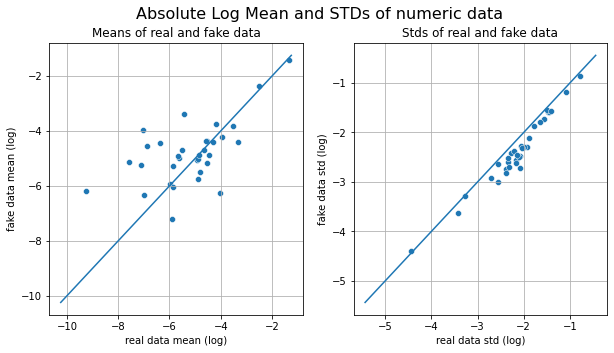

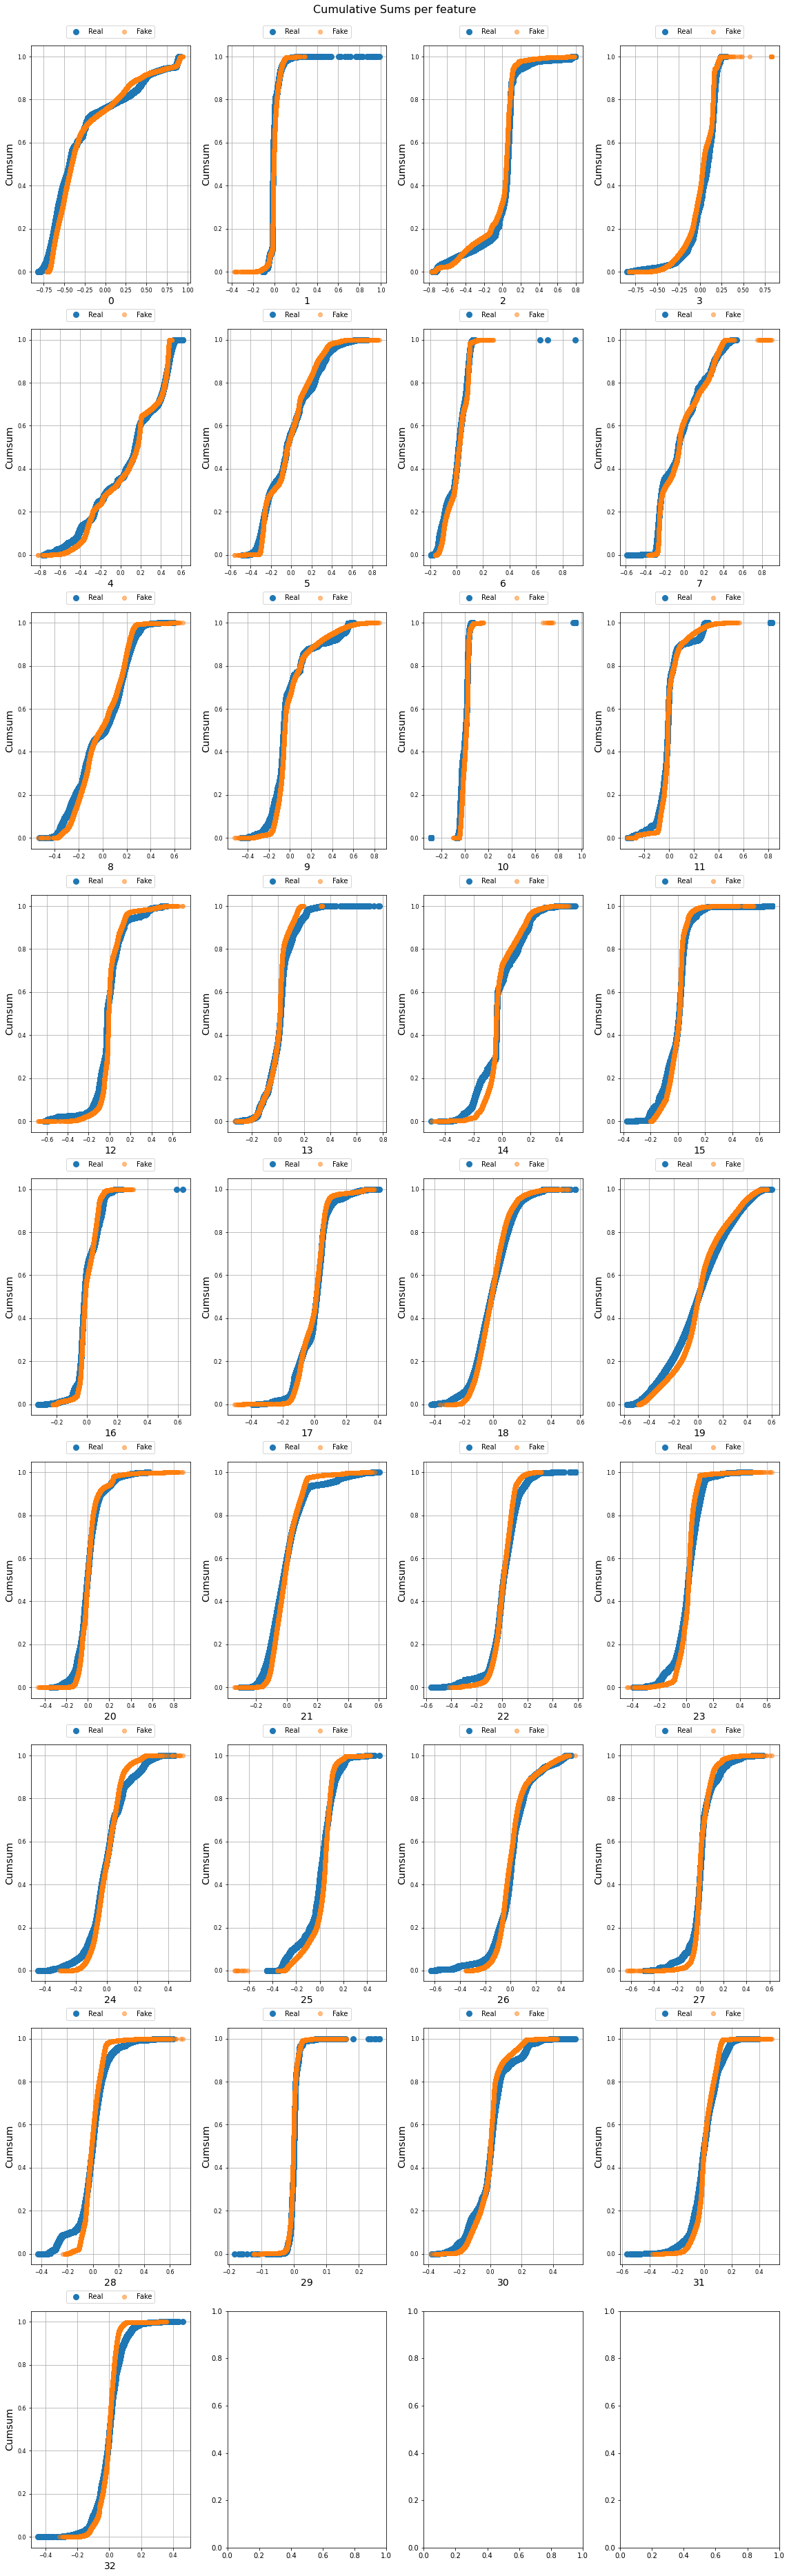

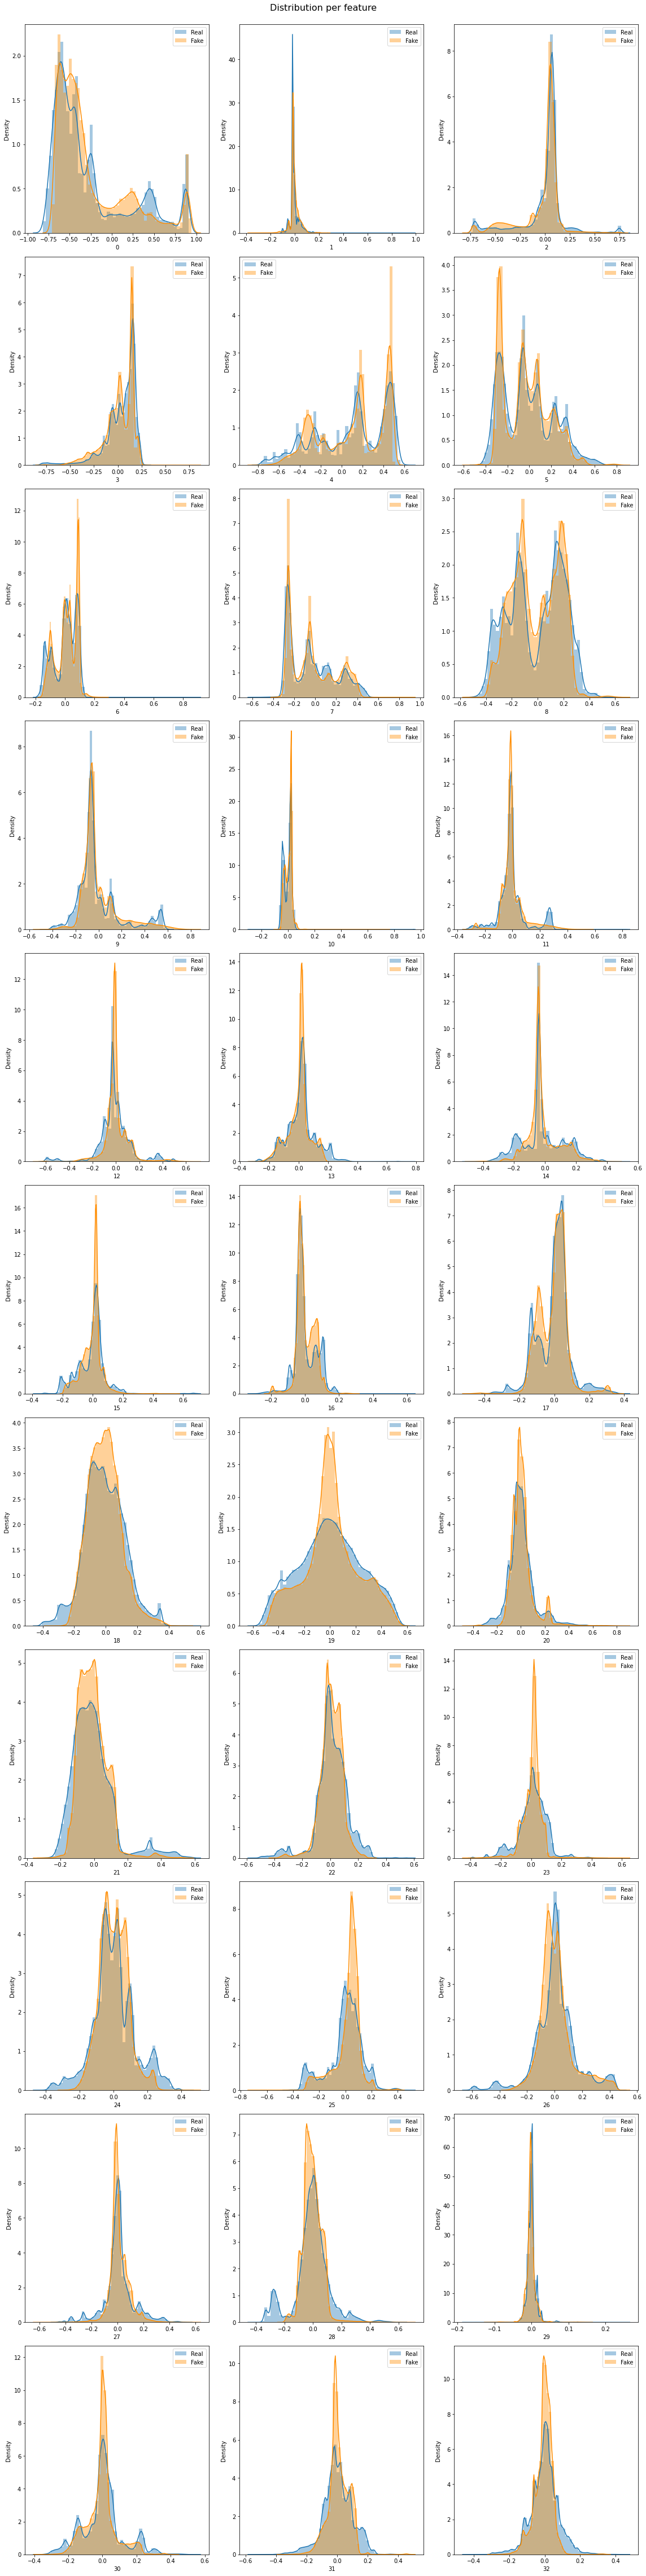

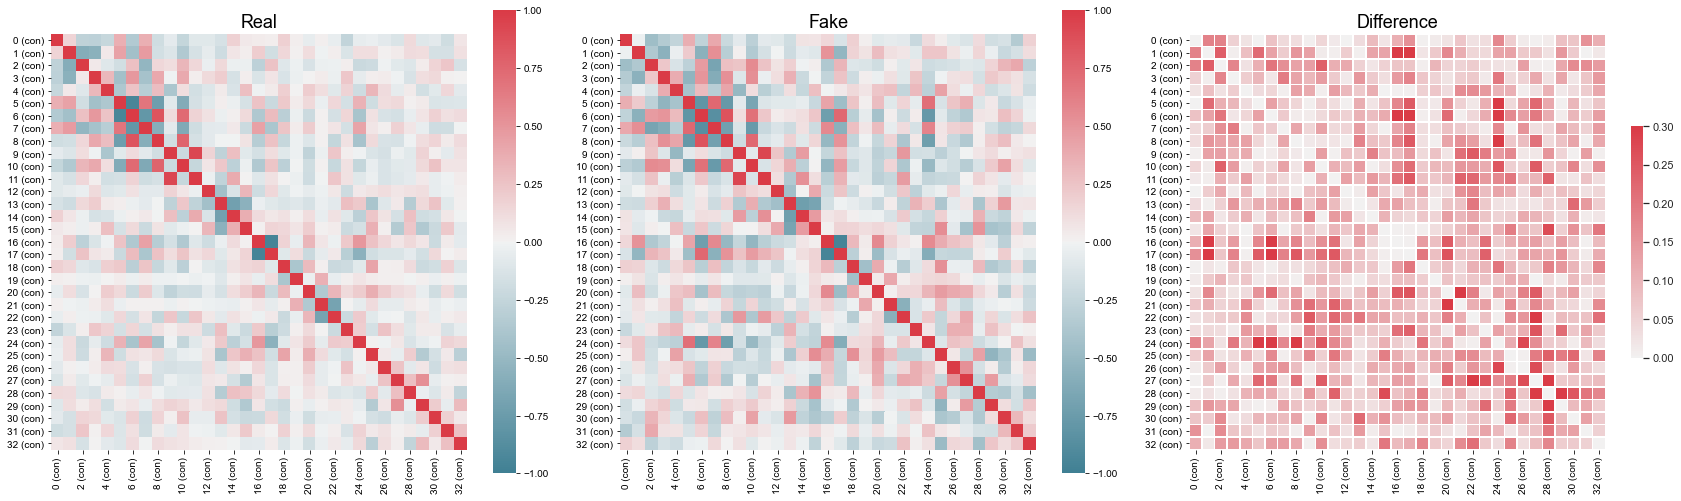

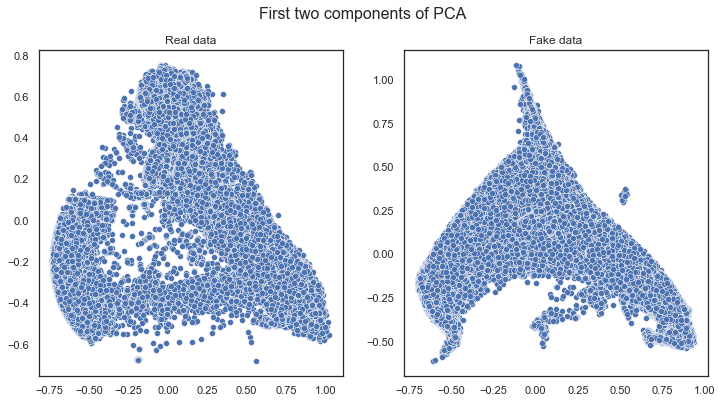

In [11]:
table_evaluator.visual_evaluation()

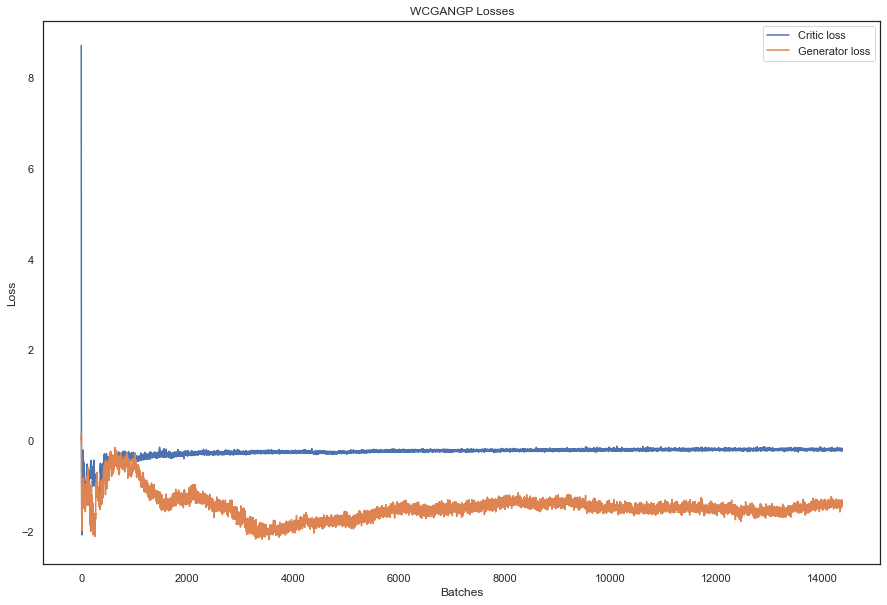

In [12]:
plt.figure(figsize=(15,10))
plt.plot(wcgan.losslog)
plt.title("WCGANGP Losses")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend(['Critic loss', 'Generator loss'])

**Saving models**

In [13]:
wcgan.generator.save("models/generator.h5")
wcgan.critic.save("models/critic.h5")